In [1]:
#hide
from fastbook import *

# CNN Interpretation with CAM

In the previous chapter we discussed about the forward pass,backward pass and also about matrix
multiplication in much detailed.We also learna about creating a neuron from scratch.We also 
focused on some PyTorch basics and elementwise operations and Broadcasting.
This chapter would be focussing on a completely new topic called class activation maps also known
as CAMs.It is related to CNNs and used for interpreting its results.

We will also introduce one of the features of PyTorch we haven't discussed before known as hook.
Let's then learn about CAM and hook.


## CAM and Hooks

Class Activation Maps(CAMs) are used in Computer Vision specially in Image classification.We can
inspect the image to be classified and makes us understand the pixels/part of the image which has
contributed most to the final output.It considers the last layer of the CNN(before the average
pooling layer) and gives a heatmap type of representation.This is useful in interpreting the 
model.

In the last convolutional layer at each position there are many filters equal to the ones in last
linear layer.Thus we calculate the dot product of the activations with the weights for every
location on feature map.The score is then used to make the final decision for class.

To get the activations we need access to them while the model is training.Hook is one of the ways
it can be done in PyTorch.Hooks are equivalent to callbacks in PyTorch.But as we had inserted
the code for callbacks in fastai's Learner using hooks we can insert codes in forward and 
backward calls.It can be inserted into any layer and executed durinf forward pass or backward 
pass.It is also known as forward hook and backward hook.Forward hook contains a module,an input
and its output.Let's first train a cat and dog classifier we had trained earlier and then define
a hook for the model.

In [2]:
#Training a cat/dog classifier
path = untar_data(URLs.PETS)/'images'#download and extract the dataset
def is_cat(x): return x[0].isupper()#labelling function
dls = ImageDataLoaders.from_name_func(#creating dataloaders for the data
    #pass path,get_image_files,validation percent,random state,label function,item tfms,
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224),num_workers=0)
learn = cnn_learner(dls, resnet34, metrics=error_rate)#creating learner for training
#dataloaders,pre_trained model,metrics
learn.fine_tune(1)#train the model for one epoch

epoch,train_loss,valid_loss,error_rate,time
0,0.139323,0.043860,0.012179,02:33


epoch,train_loss,valid_loss,error_rate,time
0,0.060720,0.041331,0.013532,02:43


To start with we would first store a cat image and store the first batch of the data from the
dataloaders object.

In [3]:
#Getting a cat image and a batch of test data
img = PILImage.create(image_cat())#cat image
x, = first(dls.test_dl([img]))#first batch in test data

Previously we mentioned that CAM use activations of the last layer of the convolutional network,
so we create a class Hook and define a hook function inside it so that it can be used later.And
it will store a copy of the output.

In [4]:
#Hook class for storing the output copy
class Hook():
    def hook_func(self, m, i, o): #hook function(model,input,output)
        self.stored = o.detach().clone()#stores output copy

Next we create an object of Hook class and then it can be attached to any layer.So we attach it 
to the last layer of the CNN model.

In [5]:
#Creating a Hook object and then attaching it to the last layer of CNN body
hook_output = Hook()#Instantiating Hook class
hook = learn.model[0].register_forward_hook(hook_output.hook_func)#Adding it to last layer

Next we detach the gradient calculation using torch.no_grad and then pass the batch of the 
dataloaders we had stored earlier through the model.(x)

In [6]:
with torch.no_grad(): #stopping the gradient calculation
    output = learn.model.eval()(x)#feeding the batch of the data through the model

Now we can access the activations of the last layer using the stored variable. 

In [7]:
#Accessing the activations of the last layer
act = hook_output.stored[0]

Previously we took a cat image from the dataset and fed it through the model.Let'see what the 
predictions are.Since it is a Image classification problem so we apply softmax function to the 
predictions.

In [8]:
#Applying softmax to the predictions.
F.softmax(output, dim=-1)

tensor([[1.6982e-06, 1.0000e+00]], device='cuda:0')

We know that it's a binary classification problem and 0 stands for dog and 1 represents cat.From
the probabilities we can say that the image belongs to cat due to high probability.Let's check 
the vocab.

In [9]:
#vocab of the dataset
dls.vocab

(#2) [False,True]

So model correctly predicted that the image is Cat.

For CAM we need to take the dot product of the weight matrix and the activations(bs X act X nrow
X ncol).In the last chapter we had discussed about Einstein Summation.So we use einsum to do the 
dot product of the matrices.

In [10]:
#shape of the first batch image
x.shape

torch.Size([1, 3, 224, 224])

Let's do matrix multiplication now between the weight matrix and the activations.We get the
weights of the last layer using learn.model[1][-1].weight and activations we had stored 
previously using the hook function.

In [11]:
#dot product of the weights and activations of the last model
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape#feature map generated using the product

torch.Size([2, 7, 7])

We get a 7 X 7 feature map for every image in the batch and for every class.It gives us the 
distributions of the activations.Using color gradient representation we can then indentify which 
areas of the image are more important for classification.

We can find out about those areas of the image which are responsible for cat classification.For
that the input is decoded using decode method and then casted to TensorImage

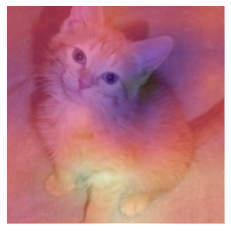

In [12]:
#Finding the area important for classification
x_dec = TensorImage(dls.train.decode((x,))[0][0])#decoding the input and casting into TensorImage
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),#plot the featuremap with
          #color gradient
              interpolation='bilinear', cmap='magma');

In the image we can see a color gradient with pink,orange,red and yellow colors for different 
parts of the image.The bright yellow parts correspond to high activations and the purple areas 
represent low activations.Using this we can conclude that the head and front paws are the two
main areas through which model decides if it's a cat.

Since we are done with using hook it can be removed by using simply remove() as it may leak
memory.

In [13]:
#removing hook
hook.remove()

In these types of conditions when we want to allocate and release the resources as per the use 
then context managers are best to use.It lets us register hook whenever we enter it and we can 
remove it when we exit.Conext Manager has an "__enter__" call when the object is created in with
and an "__exit__" call whenever there is end of with close.Basically removing the hook object.
Let's define hook as a Context Manager then..

In [14]:
#Hook using Context Manager
class Hook():
    def __init__(self, m):#passing the model's last layer
        self.hook = m.register_forward_hook(self.hook_func)#Attaching the hook to the last layer
    def hook_func(self, m, i, o):#model,input,output 
        self.stored = o.detach().clone()#storing a copy of the output prediction
    def __enter__(self, *args):#creating the object in Context manager
        return self
    def __exit__(self, *args): #exit call for removing hook
        self.hook.remove()#removing hook when there is exit 

Let's use this hook now as we had done previously.Pass the last layer of the model through hook
then after detaching the gradients,we store the predictions in a variable like output.

In [15]:
#using the hook function to store the activations
with Hook(learn.model[0]) as hook:#passing last layer of the model
    with torch.no_grad(): #removing the last gradient history
        output = learn.model.eval()(x.cuda())#model in evaluation mode
    act = hook.stored#store the activations

Fastai provides a Hook class separately but the problem is it works only for last layer.Let's 
learn about Gradient CAM which can solve this issue..

## Gradient CAM

In the previous section we discussed about CAM which produces a heatmap of the last layer
activations.We use hook to store those activations.We then multiply the activations with the 
weight matrix.But we cannot do this for the inner layers in the model.When in last chapter we 
discussed about the backward pass we can conclude from there that the gradients of the output of 
the last layer with respect to the input of that layer is equal to the weights of that layer as
its a linear layer as it's a linear layer.We can also conclude this from the Wx+b equation also.

In the inner layers,the gradients won't be equal to weights only but.They would also involve 
other equations and we have to calculate them.PyTorch calculates gradients for every layer during
backward pass but they are stored only in conditions if we provide require_grad=True as argument
in any tensor.Thus hook can serve this purpose.In the same way as we used it to store the 
activations of the last layer,we can create a hook during backward pass and PyTorch passes it as
arguments so it can be stored.Next we create a HookBwd() class for these which is similar to 
hook but stores gradients and not activations.Only difference here is that instead of 
register_forward_hook we use register_backward_hook so that it stores gradients in Backward pass.

In [16]:
#Backward hook class
class HookBwd():
    def __init__(self, m):#pass the model layer
        self.hook = m.register_backward_hook(self.hook_func)#attaching hook to the inner layer 
    def hook_func(self, m, gi, go): #model,gradient input,gradient output
        self.stored = go[0].detach().clone()#store the copy of the last gradient
    def __enter__(self, *args): #registering a hook object
        return self
    def __exit__(self, *args): 
        self.hook.remove()#removing hook in exit

Now as the class for cat is 1,so take the features of the last convolutional layer and calculate 
the gradients for the output activations for the "cat" class.We cannot simply calculate the 
gradient using output.backward as they have to be with respect to a scalar which is loss in most 
of the cases.To calculate the gradients with respect to loss,we take the first image and with 
the class(cat class) and then apply backward method on it.This computes gradient with respect to
class.Next we use stored method to store the gradients.The hook gives gradients that can be used 
as weights.

In [17]:
#Applying backward hook to store the gradients for the inner layers
cls = 1#class for cat
with HookBwd(learn.model[0]) as hookg:#model through the backward hook
    with Hook(learn.model[0]) as hook:#model through the forward hook
        output = learn.model.eval()(x.cuda())#get the model in evaluation mode
        act = hook.stored#store the activations
    output[0,cls].backward()#calculating gradient with respect to loss
    grad = hookg.stored#store the gradients

The weights for the Gradient CAM are equal to the mean of the gradients stored.This is now 
similar to the previous hook.

In [18]:
#mean of the gradients to get the weights
w = grad[0].mean(dim=[1,2], keepdim=True)#weights
cam_map = (w * act[0]).sum(0)#get the activations map by multiplying the weights with activations

Next we plot the activations map with the color gradient.

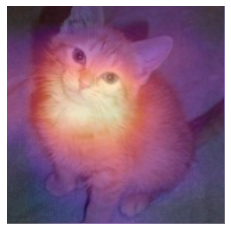

In [19]:
#plotting the activation maps with color gradient
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

As previously the bright yellow parts represent the areas with higher activations and here it is
the area with the front face.

The uniqueness with the Gradient CAM is that we can use it with any layer.Let's apply it on the 
last second layer of the resnet model.The code remains the same except the layer index this time 
is -2.

In [20]:
#Applying Gradient CAM to last second layer
with HookBwd(learn.model[0][-2]) as hookg:#Backward hook last second layer passed
    with Hook(learn.model[0][-2]) as hook:#forward hook
        output = learn.model.eval()(x.cuda())#model in evaluation mode for the same cat image
        #input
        act = hook.stored#store the activations
    output[0,cls].backward()#calculate the gradients
    grad = hookg.stored#store the gradient

In [21]:
#mean of the gradients to get weights
w = grad[0].mean(dim=[1,2], keepdim=True)#averaging gradientss
cam_map = (w * act[0]).sum(0)#getting activation map by multiplying the activations with the 
#weights calculated and summing up the elements

Next we plot the activation map for this layer as usual with color gradient.

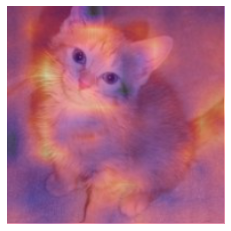

In [22]:
#plotting activation map for last second layer
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

This time the face and paws are not the main areas instead the fur,ears,forehead and legs are 
also highlighted.This show how different layers identify different parts in the image.

## Conclusion

Unlike other chapters in this chapter we discussed about model interpretation.It is a big area 
with lots of ongoing research and we just touched a basic part of it.Class activation maps give 
us a visual and easy to understand reason that why model predicted the particular image as 
particular class.It identifies the areas in the image responsible for a particular prediction.
This helps us in figuring out the reason for false positives and that the type of data which is 
missing in training.

## Questionnaire

1. What is a "hook" in PyTorch?
1. Which layer does CAM use the outputs of?
1. Why does CAM require a hook?
1. Look at the source code of the `ActivationStats` class and see how it uses hooks.
1. Write a hook that stores the activations of a given layer in a model (without peeking, if possible).
1. Why do we call `eval` before getting the activations? Why do we use `no_grad`?
1. Use `torch.einsum` to compute the "dog" or "cat" score of each of the locations in the last activation of the body of the model.
1. How do you check which order the categories are in (i.e., the correspondence of index->category)?
1. Why are we using `decode` when displaying the input image?
1. What is a "context manager"? What special methods need to be defined to create one?
1. Why can't we use plain CAM for the inner layers of a network?
1. Why do we need to register a hook on the backward pass in order to do Grad-CAM?
1. Why can't we call `output.backward()` when `output` is a rank-2 tensor of output activations per image per class?

### Further Research

1. Try removing `keepdim` and see what happens. Look up this parameter in the PyTorch docs. Why do we need it in this notebook?
1. Create a notebook like this one, but for NLP, and use it to find which words in a movie review are most significant in assessing the sentiment of a particular movie review.

# Answers:-
    

Ans-1 Hook is the PyTorch equivalent of the callbacks in fastai.We can insert any piece of code
into the forward and backward pass and it can be inserted in any layer of the model.

Ans-2 CAM uses the output of the last convolutional layer(layer just before the average pooling 
layer) and gives a heatmap representation of the areas responsible for classification in the 
image.

Ans-3 CAM requires to store the activations of the last layer of the model when it's training.It
can be done using hook.

Ans-5 class Hook():
       def __init__(self,m):
            self.hook=m.register_backward_hook(self.hook_func)
       def hook_func(self,m,gi,go):
            self.stored=o.detach().clone()
       def __enter__(self,*args):
            return self
       def __exit__(self,*args):
            self.hook.remove()

Ans-6 While passing a batch image through the model we use no_grad as we do not want the gradient
calculation for that particular step and since we need activations as the output so we pass the 
input image through the model in evaluation mode so as to get predictions as output.

Ans-8 Using dls.vocab.The order of the categories in the vocab is same as the order of the 
probabilities in the prediction.

Ans-9 We use decode while displaying the input image as it's normalized by the Dataloader as part
of the augmentation process.

Ans-10 Context Manager allows us to allocate and release resources whenever we wish to.With 
statement is very common in Context Manager.Here it registers the hook when it calls __enter__ 
and removes hook when it calls __exit__. 

Ans-11 For last layer the gradient of the output with respect to input is equal to weight,so in 
plain CAM we use weights of the last layer as the gradient to multiply with the activations to
get the feature map.But for inner layers, the gradients won't be equal to the weights alone.It 
would have other terms as well.So we have to use gradient-CAM for other layers.

Ans-12 For Gradient CAM we need to register the hook on backward pass as we are calculating the 
gradients for the inner layers and then we take their mean so as to get the weights.

Ans-13 We need gradients with respect to a scalar like loss so if we take a single image and a 
class and then use backward() method we get gradients with respect to single value.